# Automated Essay Scoring

## 1. Business Understanding

Teaching students how to write well is essential since it enables them to convey their ideas, offer arguments that persuade others and ultimately to succeed in their personal and academic endevours [(McNamara, 2015)](https://www.sciencedirect.com/science/article/abs/pii/S1075293514000427). As such, writing exercises such as essays are a powerful tool for evaluating and preparing students in this area. However, grading essays manually is time-consuming and expensive for states. As a result, educational institutions opt in for multiple-choice standardized tests instead . Thus, developing high-fidelity automated essay scoring tools is of utmost importance.

## 2. Exploratory Data Analysis

In [1]:
%reset

In [2]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import spacy
import sys
sys.path.append('./src')

import feature_engineering, preprocessing, visualizations, post_processing
from feature_engineering import extract_features_bulk
from preprocessing import normalize_scores
from post_processing import denormalize_scores
from visualizations import compare_raters

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, cohen_kappa_score
# from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
importlib.reload(feature_engineering)
importlib.reload(preprocessing)
importlib.reload(visualizations)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'visualizations' from 'd:\\DS_Flat_Iron\\Phase_V\\project\\education_early_intervention\\./src\\visualizations.py'>

**Note:** To make the work reproducible and avoid including somewhat complicated instructions on how to pull/download the data from Kaggle, I've included the necessary files being used in the root directory of the project. 

In [ ]:
df = pd.read_csv('./training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1', index_col=0)
df.head(2)

,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
essay_id,,,,,,,,,,,,,,,,,,,,,
1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.1. The Dataset
The dataset is from "The Hewlett Foundation: Automated Essay Scoring" competition on Kaggle ([Link](https://www.kaggle.com/competitions/asap-aes)). It contains manually-scored essays. The dataset contains 8 essay sets from students grade 7 to 10. On average, each essay is approximately 150 to 550 words in length. Each essay set, has its own prompt, rubric and score range. All essays are scored by two graders and at times of stark contrast between the two grades, a third grader has scored the essay. Except for essay set 2, all essays have a final score field that can be used as the target variable in this study. Essay set #2 was scored by graders in two different domains (in the original competition, it's asked that two different scores be outputted for this essay set). For simplicity, we only use the scores from domain one for this essay set in the present study. 


In [5]:
df.isna().sum()

essay_set             0
essay                 0
rater1_domain1        0
rater2_domain1        0
rater3_domain1    12848
domain1_score         0
rater1_domain2    11176
rater2_domain2    11176
domain2_score     11176
rater1_trait1     10684
rater1_trait2     10684
rater1_trait3     10684
rater1_trait4     10684
rater1_trait5     12253
rater1_trait6     12253
rater2_trait1     10684
rater2_trait2     10684
rater2_trait3     10684
rater2_trait4     10684
rater2_trait5     12253
rater2_trait6     12253
rater3_trait1     12848
rater3_trait2     12848
rater3_trait3     12848
rater3_trait4     12848
rater3_trait5     12848
rater3_trait6     12848
dtype: int64

In [6]:
cols_to_keep = ['essay_set', 'essay', 'rater1_domain1', 'rater2_domain1', 'domain1_score']
df = df[cols_to_keep]
df.rename(columns={'rater1_domain1':'rater1_score','rater2_domain1':'rater2_score', 'domain1_score':'final_score'}, inplace=True)
df.head()

,essay_set,essay,rater1_score,rater2_score,final_score
essay_id,,,,,
1,1,"Dear local newspaper, I think effects computer...",4,4,8
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


The following figure shows how many essays exist in each set sorted in a descending manner from left to right. 

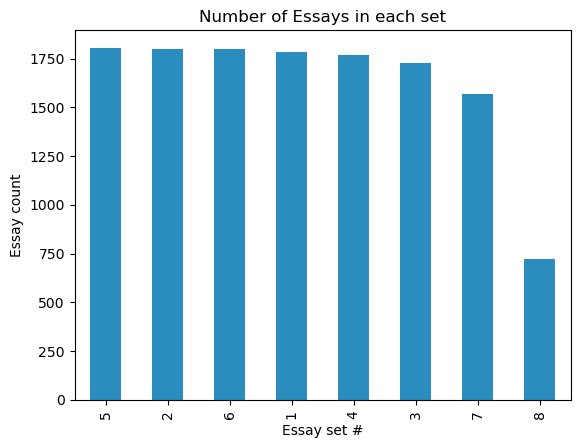

In [7]:
fig, ax = plt.subplots()
df.groupby('essay_set').size().sort_values(ascending=False).plot(kind='bar', xlabel = 'Essay set #', ylabel = 'Essay count', title="Number of Essays in each set",color="#2b8cbe");

In [13]:
df.shape

(12976, 8)

### 2.1. Distribution of scores and agreement of human raters
Each set of essays has its own score range (outlined in the code cell below). In order to visualize the distribution of scores for all essays and later on use them as one single training set, we need to normalize the scores. We choose to normalize all scores to the range 0-10 through a linear transformation. 

In [8]:
# min-max range for each essay set
num_essay_sets = len(df['essay_set'].unique())
rubric_range = {
    1: {'rater_min': 1, 'rater_max': 6, 'final_min': 2, 'final_max': 12},
    2: {'rater_min': 1, 'rater_max': 6, 'final_min': 1, 'final_max': 6},
    3: {'rater_min': 0, 'rater_max': 3, 'final_min': 0, 'final_max': 3},
    4: {'rater_min': 0, 'rater_max': 3, 'final_min': 0, 'final_max': 3},
    5: {'rater_min': 0, 'rater_max': 4, 'final_min': 0, 'final_max': 4},
    6: {'rater_min': 0, 'rater_max': 4, 'final_min': 0, 'final_max': 4},
    7: {'rater_min': 0, 'rater_max': 15, 'final_min': 0, 'final_max': 30},
    8: {'rater_min': 0, 'rater_max': 30, 'final_min': 0, 'final_max': 60}
}

In [9]:
for i in range(num_essay_sets):
    mask = df['essay_set'] == i+1
    df.loc[mask, 'rater1_score_norm'] = df.loc[mask].apply(normalize_scores, axis=1, 
                                                            args=('rater1_score', rubric_range[i+1]['rater_min'], rubric_range[i+1]['rater_max']))
    df.loc[mask, 'rater2_score_norm'] = df.loc[mask].apply(normalize_scores, axis=1, 
                                                            args=('rater2_score', rubric_range[i+1]['rater_min'], rubric_range[i+1]['rater_max']))
    df.loc[mask, 'final_score_norm'] = df.loc[mask].apply(normalize_scores, axis=1, 
                                                            args=('final_score', rubric_range[i+1]['final_min'], rubric_range[i+1]['final_max']))
df.head()

,essay_set,essay,rater1_score,rater2_score,final_score,rater1_score_norm,rater2_score_norm,final_score_norm
essay_id,,,,,,,,
1,1,"Dear local newspaper, I think effects computer...",4,4,8,6.0,6.0,6.0
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,8.0,6.0,7.0
3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,6.0,4.0,5.0
4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,8.0,8.0,8.0
5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,6.0,6.0,6.0


**Inter-Rater Reliability (IRR):**  
IRR refers to how well raters agree given the same input data. Since we will evaluate the machine learning models based on how well they agree with human raters, it's important to have a benchmark for how well human raters agree among themselves (Ghanta, 2019). In this section, we visualize the agreement between raters 1 and 2 for individual essay sets, as well as all essays. 

Note that normalization of scores and binning them can affect Cohen's Kappa in unexpected ways. Therefore, the Cohen's Kappa is determined for each essay set individually, using the original rubric range. In the end, the mean over all coefficients is used as the average agreement score between human raters. 

In [12]:
df['final_score_norm'].describe()

count    12976.000000
mean         5.809379
std          2.342421
min          0.000000
25%          4.000000
50%          6.000000
75%          7.500000
max         10.000000
Name: final_score_norm, dtype: float64

Average of Cohen's Kappa is: 0.75
Standard deviation of Cohen's Kappa is: 0.07


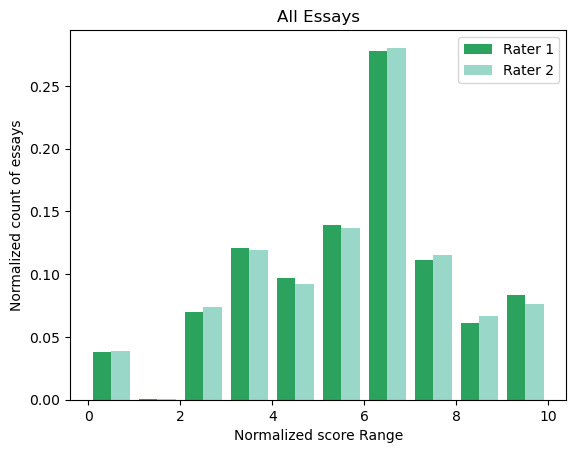

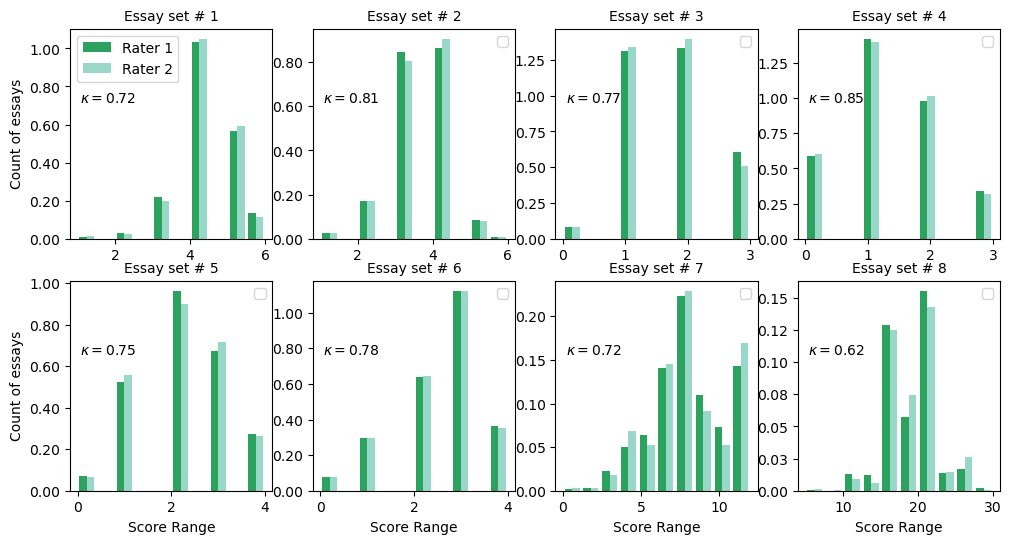

In [10]:
compare_raters(df)

As it can be seen, the average of Kohen's Kappa across all 8 sets of essays is 0.75 $\pm$ 0.07. This indicates substantial agreement among human raters. This baseline is important since we would like to compare the agreement between a human rater with the automated scoring system. 

**Summary:**
- The dataset contains 8 sets of essays and  roughly 13000 essays total. 
- All essay sets except set 8 contain more than 1000 essays. 
- A normalized grade range (0-10) is used to linearly scale all essay set scores and define a target variable to be used during training. 
- Once normalized to a 0-10 range, the mean and standard deviation of final scores are 5.8 and 2.3 respectively. 
- Cohen's Kappa for the two human raters grading the essays has a mean of 0.75 and a standard deviation of 0.07.

### 2.1. Feature Engineering


In order to build an automated essay scorer, we will need to first extract appropriate features from the essays. In the literature, features extracted by Coh-Metrix are typically used (for example, McNamara et al. 2014 and Ghanta, 2019). Coh-Metrix is a program that uses natural language processing to analyze discourse. It calculates a number of linguistic indices related to various aspects of language that can be used to determine the quality, readability and other specific properties of a written or spken text ([Ref](https://soletlab.asu.edu/coh-metrix/)). To the best of my knowledge, Coh-Metrix doesn't have a python implementation for the English language. Therefore, in the present study, a number of the more accessible Coh-Metrix-like features are computed using the *extract_features_bulk* function under the *feature_engineering* module. These features are engineered to capture the descriptive essence of essays as well as more complicated measures, such as text easability, referential cohesion, lexical diversity, connectiveness, syntactic complexity and readability. The table below includes the feature names and a corresponding short description for each. 

| Feature Name             | Explanation                                                                                          |
|--------------------------|------------------------------------------------------------------------------------------------------|
| num_words                | The total number of words in the essay. It provides an overall measure of essay length.              |
| num_sentences            | The total number of sentences in the essay. This is an indicator of the essay's structure.            |
| avg_sentence_length      | The average number of words per sentence. It gives an indication of sentence complexity.              |
| std_sentence_length      | The standard deviation of sentence lengths. This shows the variability in sentence structure.         |
| avg_syllable_count       | The average number of syllables per word. It reflects the complexity and sophistication of the words. |
| std_syllable_count       | The standard deviation of syllable counts across words. This shows the variation in word complexity.  |
| avg_letter_count         | The average number of letters per word. It gives an idea of word length and lexical richness.         |
| std_letter_count         | The standard deviation of letter counts per word. This measures the variability in word length.       |
| flesch_reading_ease      | A readability score indicating how easy the text is to read. Higher scores indicate easier readability.|
| flesh_kincaid_grade      | A grade-level readability score. This indicates the U.S. school grade level required to understand the text.|
| smog_index               | A readability measure based on sentence length and complex words. It provides a gauge of readability difficulty.|
| lexical_diversity        | The ratio of unique words to total words. Higher values suggest a richer vocabulary.                  |
| num_stopwords            | The proportion of stopwords in the text. A high proportion may indicate simpler language use.        |
| num_pronouns             | The proportion of pronouns in the text. This can give insights into the personal style of the writer. |
| num_verbs                | The proportion of verbs in the text. This can indicate the action-oriented nature of the text.        |
| avg_tree_depth           | The average syntactic depth of words in the sentence. A measure of sentence complexity from a syntactic perspective. |
| avg_concreteness         | The average concreteness of the words. Concreteness correlates with the level of abstraction in the text.|
| num_misspelled           | The proportion of misspelled words. This may indicate the writer's attention to spelling or errors.    |
| lsa_overlap_avg          | The average overlap in meaning between adjacent sentences, measured using Latent Semantic Analysis.    |


In order for the model to capture the fact that the essay sets may be from different grades, with different score ranges, we add the essey_set column back in as a feature. 

In [14]:
# Note: setting make_features to True will run the extract_features_bulk function which will take ~15 minutes to run. 
# I've disabled this and I'm using the saved dataframe from a previous run to save time for anyone rerunning this notebook. Feel free to turn the flag to true and run the function.
make_features = False
if make_features:
    df_features = extract_features_bulk(list(df['essay']))
    df_features['essay_set'] = df.reset_index()['essay_set']
    df_features['target'] = df.reset_index()['final_score_norm']
    df_features['ordinal_score'] = df.reset_index()['final_score']
    print("number of NaNs:", df['final_score_norm'].isna().sum())
    df_features.to_csv('./feature_engineered_data.csv')
    

In [15]:
df_features = pd.read_csv('./feature_engineered_data.csv', index_col=0)
df_features.head()

,num_words,num_sentences,avg_sentence_length,std_sentence_length,avg_syllable_count,std_syllable_count,avg_letter_count,std_letter_count,flesch_reading_ease,flesh_kincaid_grade,...,num_stopwords,num_pronouns,num_verbs,avg_tree_depth,avg_concreteness,num_misspelled,lsa_overlap_avg,essay_set,target,ordinal_score
0,340,16,24.687500,15.369748,1.258824,0.577921,4.182353,2.068655,65.56,9.7,...,0.532353,0.141176,0.147059,3.614706,2.366471,0.026471,0.723433,1,6.0,8
1,410,20,22.800000,13.065020,1.375610,0.716819,4.290244,2.324769,67.08,9.1,...,0.475610,0.121951,0.168293,3.775610,2.231732,0.031707,0.545078,1,7.0,9
2,272,15,20.400000,13.329881,1.400735,0.747246,4.330882,2.330783,59.74,9.9,...,0.525735,0.095588,0.147059,3.459559,2.092757,0.003676,0.610131,1,5.0,7
3,485,27,21.333333,12.612570,1.468041,0.806424,4.680412,2.463563,51.78,10.9,...,0.459794,0.065979,0.148454,3.206186,2.097278,0.045361,0.784997,1,8.0,10
4,463,30,17.266667,7.153168,1.406048,0.761155,4.343413,2.306774,64.20,8.2,...,0.520518,0.088553,0.129590,2.645788,2.097473,0.019438,0.707326,1,6.0,8


Test statistics for the engineered features:

In [16]:
df_features.describe()

,num_words,num_sentences,avg_sentence_length,std_sentence_length,avg_syllable_count,std_syllable_count,avg_letter_count,std_letter_count,flesch_reading_ease,flesh_kincaid_grade,...,num_stopwords,num_pronouns,num_verbs,avg_tree_depth,avg_concreteness,num_misspelled,lsa_overlap_avg,essay_set,target,ordinal_score
count,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,...,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000
mean,217.275740,13.334849,20.583843,8.991117,1.320627,0.625550,4.246550,2.125265,69.097643,8.385512,...,0.530054,0.126862,0.149993,3.030525,2.208555,0.021428,0.585697,4.179485,5.809379,6.800247
std,171.103381,11.392213,8.422842,5.601350,0.104922,0.135983,0.363851,0.272222,13.333458,3.840904,...,0.053555,0.053572,0.034050,0.601233,0.200126,0.022148,0.204479,2.136913,2.342421,8.970705
min,2.000000,1.000000,2.000000,0.000000,1.000000,0.000000,2.818182,0.781736,-195.130000,-2.300000,...,0.176471,0.000000,0.000000,0.500000,1.024848,0.000000,-0.500000,1.000000,0.000000,0.000000
25%,96.000000,5.000000,15.968013,5.972158,1.244014,0.529749,4.017003,1.940086,61.522500,6.400000,...,0.494737,0.090667,0.128571,2.643435,2.092083,0.007092,0.487382,2.000000,4.000000,2.000000
50%,159.000000,9.000000,19.183502,8.021032,1.319672,0.631681,4.263158,2.132914,69.720000,8.000000,...,0.532258,0.129283,0.149671,2.970504,2.215581,0.016393,0.634197,4.000000,6.000000,3.000000
75%,301.000000,19.000000,23.183239,10.778215,1.394538,0.725385,4.500000,2.318996,77.430000,9.800000,...,0.566038,0.163158,0.170668,3.325166,2.346809,0.029412,0.732272,6.000000,7.500000,8.000000
max,1052.000000,114.000000,231.000000,161.927453,1.794118,1.183216,6.100000,4.054070,118.180000,114.000000,...,0.800000,0.444444,0.600000,10.988889,3.150000,0.469697,0.963359,8.000000,10.000000,60.000000


**Summary:**
- The final dataset contains roughly 13000 entries and 20 features (including essay_set). 
- The devised features are based on features constructed in the Coh-Metrix software. These features are engineered to capture the descriptive essence of essays as well as more complicated measures, such as text easability, referential cohesion, lexical diversity, connectiveness, syntactic complexity and readability. The table below includes the feature names and a corresponding short description for each. 

## 3. Machine Learning Model

Several algorithms have been used in the literature for designing automated essay scoring engines: Linear Regression, Random Forest Regressor and Linear Support Vector Regressor, to name a few. McNamara et al (2015) showed that using a hierarchical classification approach may be used with comparable accuracy and the advantage of providing better feedback to students. Transformer models  (including fine-tuned models based on existing architectures) have also been utilized to devise powerful AES engines (Ludwig et al., 2021). In this work, we use a random forest regressor. The random forest regressor has been shown to outperform other classical regression models and it can handle both numerical as well as categorical features easily (recall that we kept the categorical feature, essay_set). Although I made an attempt to fine-tune a transformer model using the HuggingFace library, the fine-tuning of such models on a standard laptop is time-intensive and out of the scope of this project.  

### Random Forest Regressor

In [180]:
df_features.head()

,num_words,num_sentences,avg_sentence_length,std_sentence_length,avg_syllable_count,std_syllable_count,avg_letter_count,std_letter_count,flesch_reading_ease,flesh_kincaid_grade,...,num_stopwords,num_pronouns,num_verbs,avg_tree_depth,avg_concreteness,num_misspelled,lsa_overlap_avg,essay_set,target,final_score
0,340,16,24.687500,15.369748,1.258824,0.577921,4.182353,2.068655,65.56,9.7,...,0.532353,0.141176,0.147059,3.614706,2.366471,0.026471,0.725964,1,6.0,8
1,410,20,22.800000,13.065020,1.375610,0.716819,4.290244,2.324769,67.08,9.1,...,0.475610,0.121951,0.168293,3.775610,2.231732,0.031707,0.545503,1,7.0,9
2,272,15,20.400000,13.329881,1.400735,0.747246,4.330882,2.330783,59.74,9.9,...,0.525735,0.095588,0.147059,3.459559,2.092757,0.003676,0.608161,1,5.0,7
3,485,27,21.333333,12.612570,1.468041,0.806424,4.680412,2.463563,51.78,10.9,...,0.459794,0.065979,0.148454,3.206186,2.097278,0.045361,0.784982,1,8.0,10
4,463,30,17.266667,7.153168,1.406048,0.761155,4.343413,2.306774,64.20,8.2,...,0.520518,0.088553,0.129590,2.645788,2.097473,0.019438,0.700912,1,6.0,8


In [209]:
X = df_features.drop(columns=['target', 'ordinal_score']).values
y = df_features['target'].values
essay_set = df_features['essay_set'].values
ord_scores = df_features['ordinal_score'].values
# Append essay set to X
# X = np.hstack([X, essay_set])

# Split train-test
X_train, X_test, y_train, y_test, es_train, es_test, ord_score_train, ord_score_test = train_test_split(X, y, essay_set, ord_scores, test_size=0.2, random_state=42)

# Random Forest + Hyperparameter tuning
rf = RandomForestRegressor()

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=25, cv=3, verbose=1,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best estimator
best_model = random_search.best_estimator_

# Cross-validation on the best model
cv = KFold(n_splits=3, shuffle=True, random_state=42)
cv_mse = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='r2')

cv_mse = -np.mean(cv_mse)
cv_r2 = np.mean(cv_r2)

print(f"Cross-validated MSE: {cv_mse:.2f}")
print(f"Cross-validated R2: {cv_r2:.2f}")

# Test set prediction
y_pred = best_model.predict(X_test)

# Test MSE and R2
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"Test MSE:{test_mse:.2f}")
print(f"Test R2:{test_r2:.2f}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Cross-validated MSE: 2.06
Cross-validated R2: 0.62
Test MSE:2.03
Test R2:0.63


**Evaluation of Cohen's Kappa:**

In [ ]:
y_pred_denorm = np.zeros_like(y_test)
y_test_denorm = ord_score_test

for i in range(len(y_test)):
    min_range = rubric_range[es_test[i]]['final_min']
    max_range = rubric_range[es_test[i]]['final_max']
    y_pred_denorm[i] = denormalize_scores(y_pred[i], min_range, max_range)
    
test_cohen_kappa = cohen_kappa_score()

Test Kappa: 0.84


## References

1. Ghanta, Harshanti, Automated essay evaluation using natural language processing and machine learning, 2019, Master of Science Thesis. [Link](https://csuepress.columbusstate.edu/theses_dissertations/327/) 
2. Ludwig, S., Mayer, C., Hanse, C., Eilers, K., Brandt, S., Automated essay scoring using transformer models. [Link](https://arxiv.org/abs/2110.06874)
2. McNamara, D., Crossley, S., Roscoe, R., Allen, L., Dai, J., A hierarchical classification approach to automated essay scoring, Assessing Writing Journal, 2015. [Link](https://www.sciencedirect.com/science/article/abs/pii/S1075293514000427)
3. McNamara, D. S., Graesser, A. C., McCarthy, P., & Cai, Z. Automated Evaluation of Text and Discourse with Coh-Metrix. Cambridge: Cambridge University Press, 2014. [Link](Automated Evaluation of Text and Discourse with Coh-Metrix. Cambridge: Cambridge University Press, 2014)